### ※ 참고 사이트:
https://medium.com/analytics-vidhya/canny-edge-detector-7b8037fa0764

# Image alignment

In this task, you will have to solve two image alignment problems: channel processing and face alignment. You can get **10 points** implementing all the passed functions (7.5 for the first part and 2.5 for the second one).

# Image channels processing and alignment (7.5 points)

## Problem review

Sergey Prokudin-Gorsky was the first color photographer in Russia, who made the color portrait of Leo Tolstoy. Each of his photographs is three black-and-white photo plates, corresponding to red, green, and blue color channels. Currently, the collection of his pictures is situated in the U.S. Library of Congress, the altered versions have proliferated online. In this task, you should make a programme which will align the images from the Prokudin-Gorsky plates and learn the basic image processing methods.


In [1]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## Problem description

#### Input image loading

The input image is the set of 3 plates, corresponding to B, G, and R channels (top-down). You should implement the function $\tt{load}$\_$\tt{data}$ that reads the data and returns the list of images of plates.
$\tt{dir}$\_$\tt{name}$ is the path to the directory with plate images. If this directory is located in the same directory as this notebook, then default arguments can be used.

In [2]:
import cv2
import os

def load_data(dir_name = 'C:/Users/JYW/Desktop/Github/repository/ComputerVision/[Coursera]Deep Learning in Computer Vision/week 1/plates'):
    images = []
    for filename in os.listdir(dir_name):
        img = cv2.imread(os.path.join(dir_name,filename))
        if img is not None:
            images.append(img)
    return images

plates = load_data()

The dataset is a list of 2-dimensional arrays.

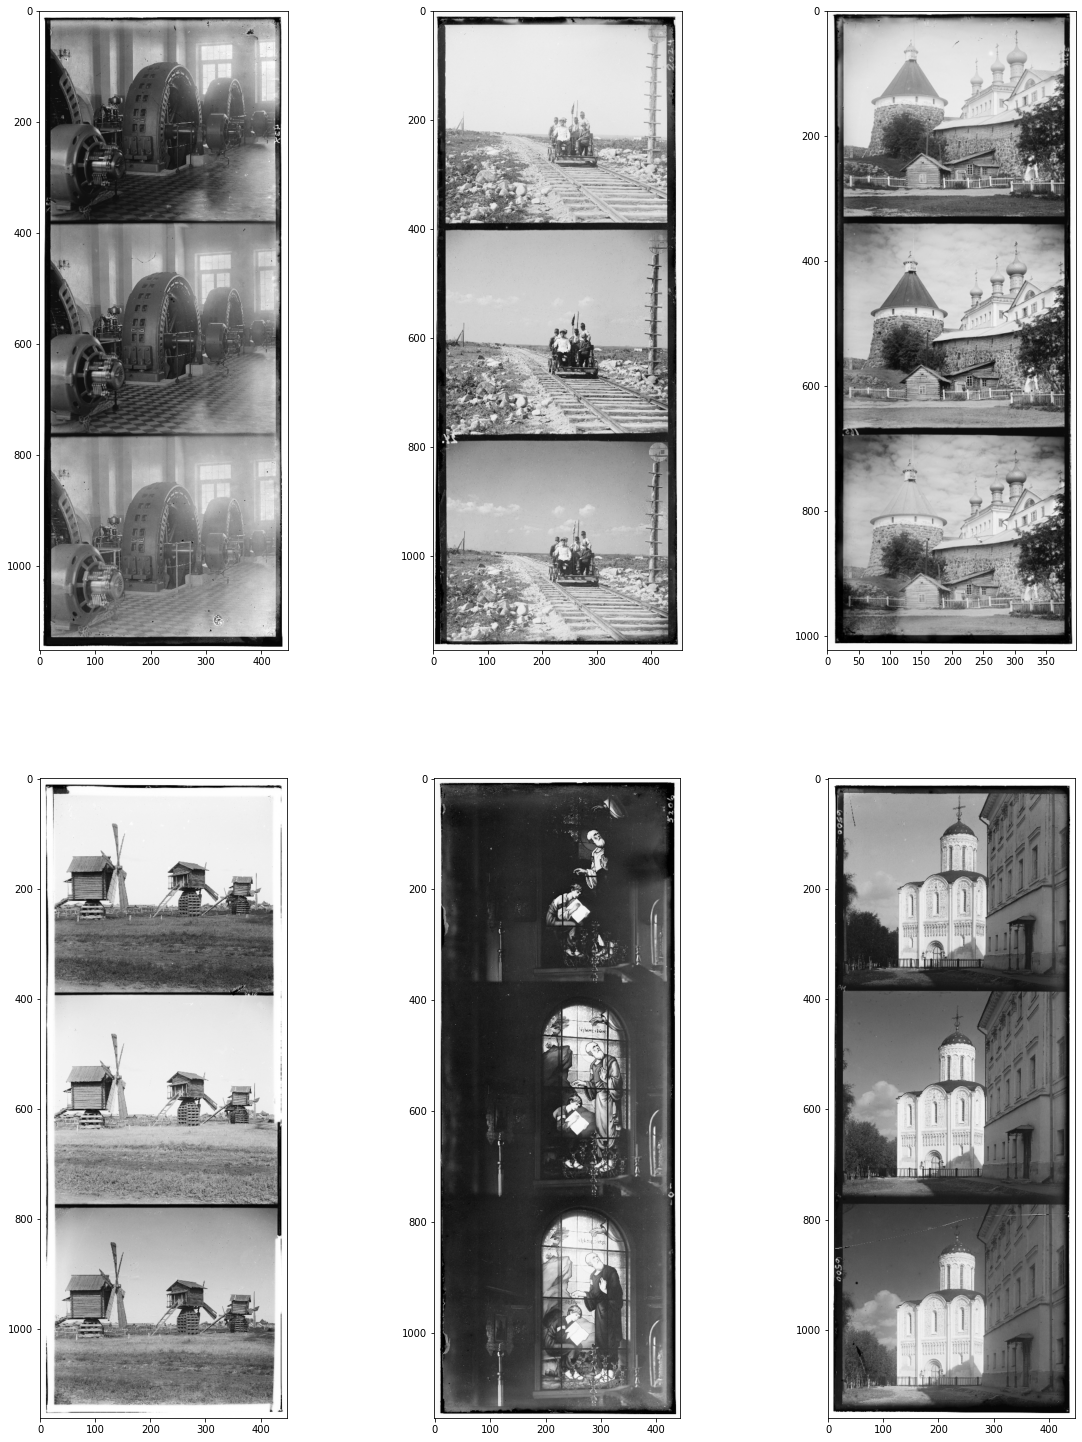

In [3]:
# The auxiliary function `visualize()` displays the images given as argument.
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

visualize(plates, 'gray')

#### Canny detector implementation (2.5 points)
You can write your own implementation of Canny edge detector to get extra points. <br>

Canny detection algorithm:
1. *Noise reduction.* To remove noise, the image is smoothed by Gaussian blur with the kernel of size $5 \times 5$ and $\sigma = 1.4$. Since the sum of the elements in the Gaussian kernel equals $1$, the kernel should be normalized before the convolution. <br><br>

2. *Calculating gradients.* When the image $I$ is smoothed, the derivatives $I_x$ and $I_y$ w.r.t. $x$ and $y$ are calculated. It can be implemented by convolving $I$ with Sobel kernels $K_x$ and $K_y$, respectively: 
$$ K_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}, K_y = \begin{pmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{pmatrix}. $$ 
Then, the magnitude $G$ and the slope $\theta$ of the gradient are calculated:
$$ |G| = \sqrt{I_x^2 + I_y^2}, $$
$$ \theta(x,y) = arctan\left(\frac{I_y}{I_x}\right)$$<br><br>

3. *Non-maximum suppression.* For each pixel find two neighbors (in the positive and negative gradient directions, supposing that each neighbor occupies the angle of $\pi /4$, and $0$ is the direction straight to the right). If the magnitude of the current pixel is greater than the magnitudes of the neighbors, nothing changes, otherwise, the magnitude of the current pixel is set to zero.<br><br>

4. *Double threshold.* The gradient magnitudes are compared with two specified threshold values, the first one is less than the second. The gradients that are smaller than the low threshold value are suppressed; the gradients higher than the high threshold value are marked as strong ones and the corresponding pixels are included in the final edge map. All the rest gradients are marked as weak ones and pixels corresponding to these gradients are considered in the next step.<br><br>

5. *Edge tracking by hysteresis.* Since a weak edge pixel caused from true edges will be connected to a strong edge pixel, pixel $w$ with weak gradient is marked as edge and included in the final edge map if and only if it is involved in the same blob (connected component) as some pixel $s$ with strong gradient. In other words, there should be a chain of neighbor weak pixels connecting $w$ and $s$ (the neighbors are 8 pixels around the considered one). You are welcome to make up and implement an algorithm that finds all the connected components of the gradient map considering each pixel only once.  After that, you can decide which pixels will be included in the final edge map (this algorithm should be single-pass, as well).

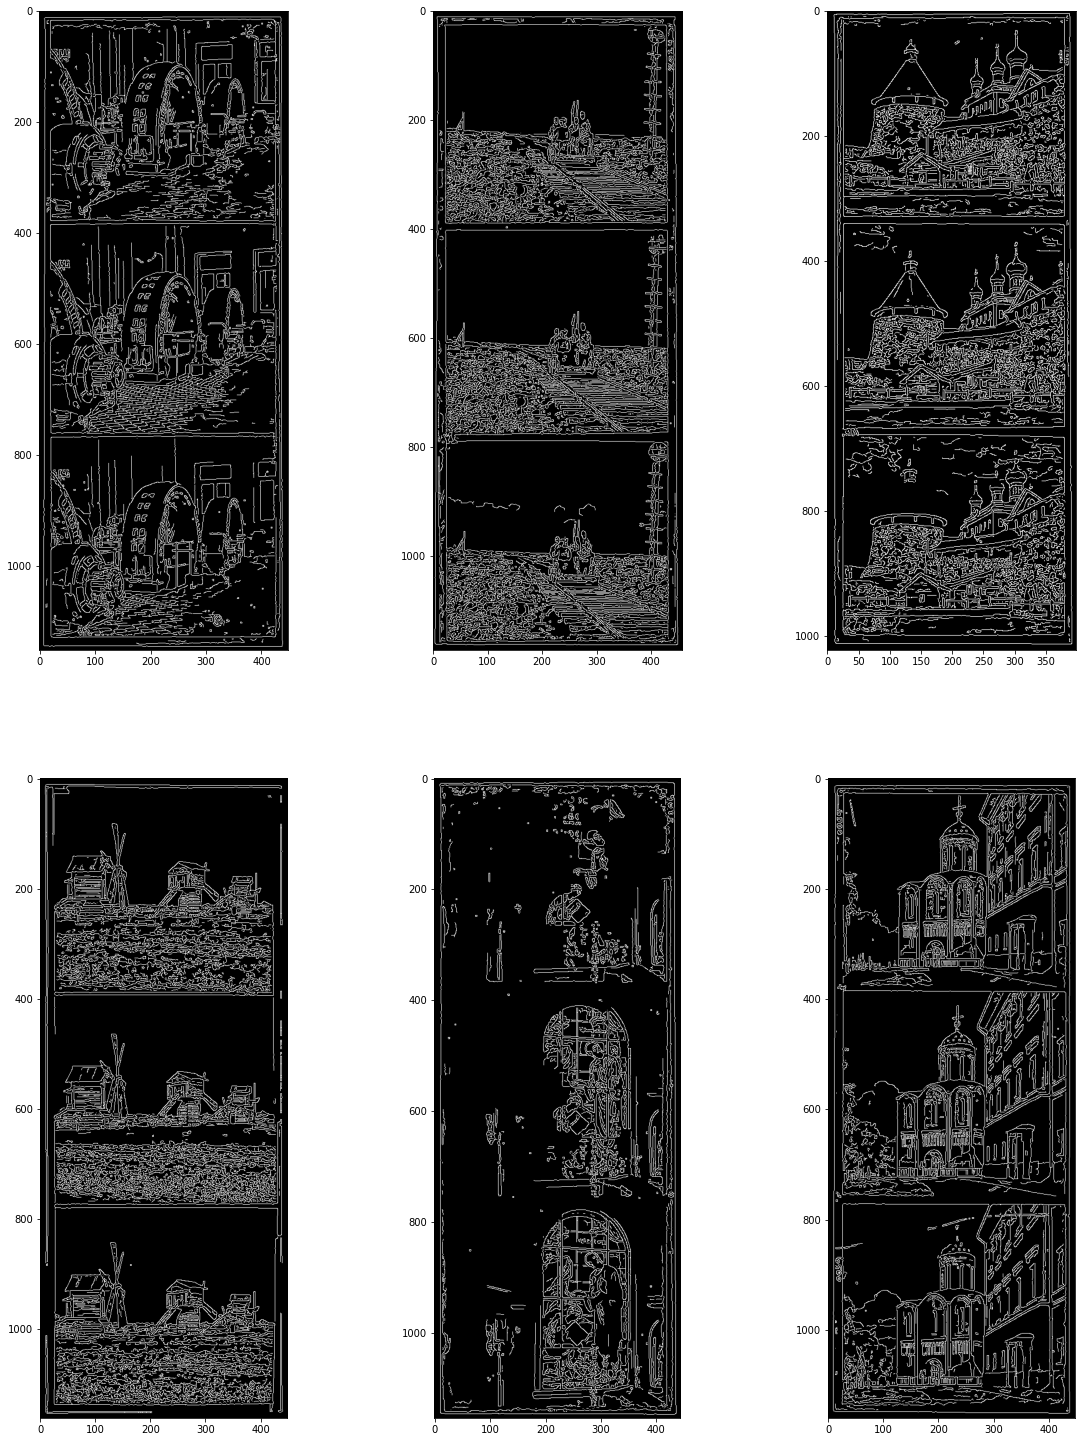

In [4]:
from  skimage.feature import canny

def Canny_detector(img):
    return canny(img[:, :, 0])

canny_imgs = []
for img in plates:
    canny_img = Canny_detector(img)
    canny_imgs.append(canny_img)

visualize(canny_imgs, 'gray')

#### Channels separation  (0.5 points)

The next step is to separate the image into three channels (B, G, R) and make one colored picture. To get channels, you can divide each plate into three equal parts.

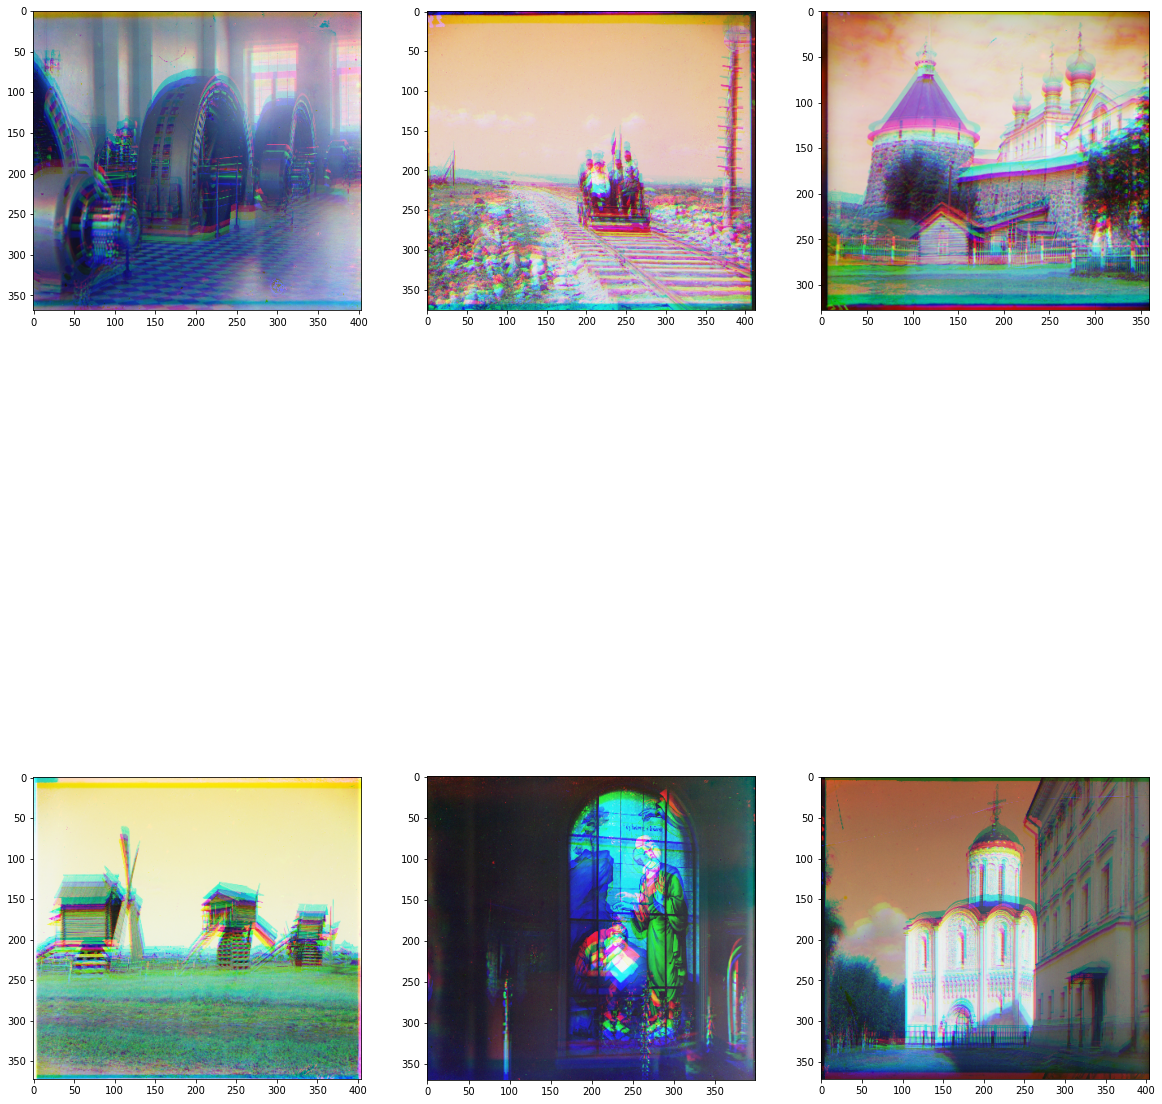

In [5]:
# Make cropped images
def remove_borders(img):   
    dx = int(img.shape[1] * 0.05) 
    return img[dx : -dx, dx : -dx]

cropped_imgs = []
#crop borders
for i, img in enumerate(plates):
    cropped_imgs.append(remove_borders(img))

def impose_components(img):
    imgs = []
    idx = int(img.shape[0]/3)
    r = img[0:idx, :, 0]
    g = img[idx:idx + idx, :, 1]
    b = img[idx + idx:idx + idx + idx, :, 2]
    imgs.append(r)
    imgs.append(g)
    imgs.append(b)
    return np.array(imgs)

rgb_imgs = []
for cropped_img in cropped_imgs:
    rgb_img = impose_components(cropped_img)
    rgb_imgs.append(rgb_img)

visualize(rgb_imgs)

# Face Alignment (2.5 points)

In this task, you have to implement face normalization and alignment. Most of the face images deceptively seem to be aligned, but since many face recognition algorithms are very sensitive to shifts and rotations, we need not only to find a face on the image but also normalize it. Besides, the neural networks usually used for recognition have fixed input size, so, the normalized face images should be resized as well.

There are six images of faces you have to normalize. In addition, you have the coordinates of the eyes in each of the pictures. You have to rotate the image so that the eyes are on the same height, crop the square box containing the face and transform it to the size $224\times 224.$ The eyes should be located symmetrically and in the middle of the image (on the height).

#### Get data
You get the images and corresponding eyes coordinates for each person. You should implement the  function $\tt{load}$\_$\tt{faces}$\_$\tt{and}$\_$\tt{eyes}$ that reads the data and returns two dictionaries: the dictionary of images and the dictionary of eyes coordinates. Eyes coordinates is a list of two tuples $[(x_1,y_1),(x_2,y_2)]$.
Both dictionaries should have filenames as the keys.

$\tt{dir}$\_$\tt{name}$ is the path to the directory with face images, $\tt{eye}$\_$\tt{path}$ is the path to .pickle file with eyes coordinates. If these directory and file are located in the same directory as this notebook, then default arguments can be used.

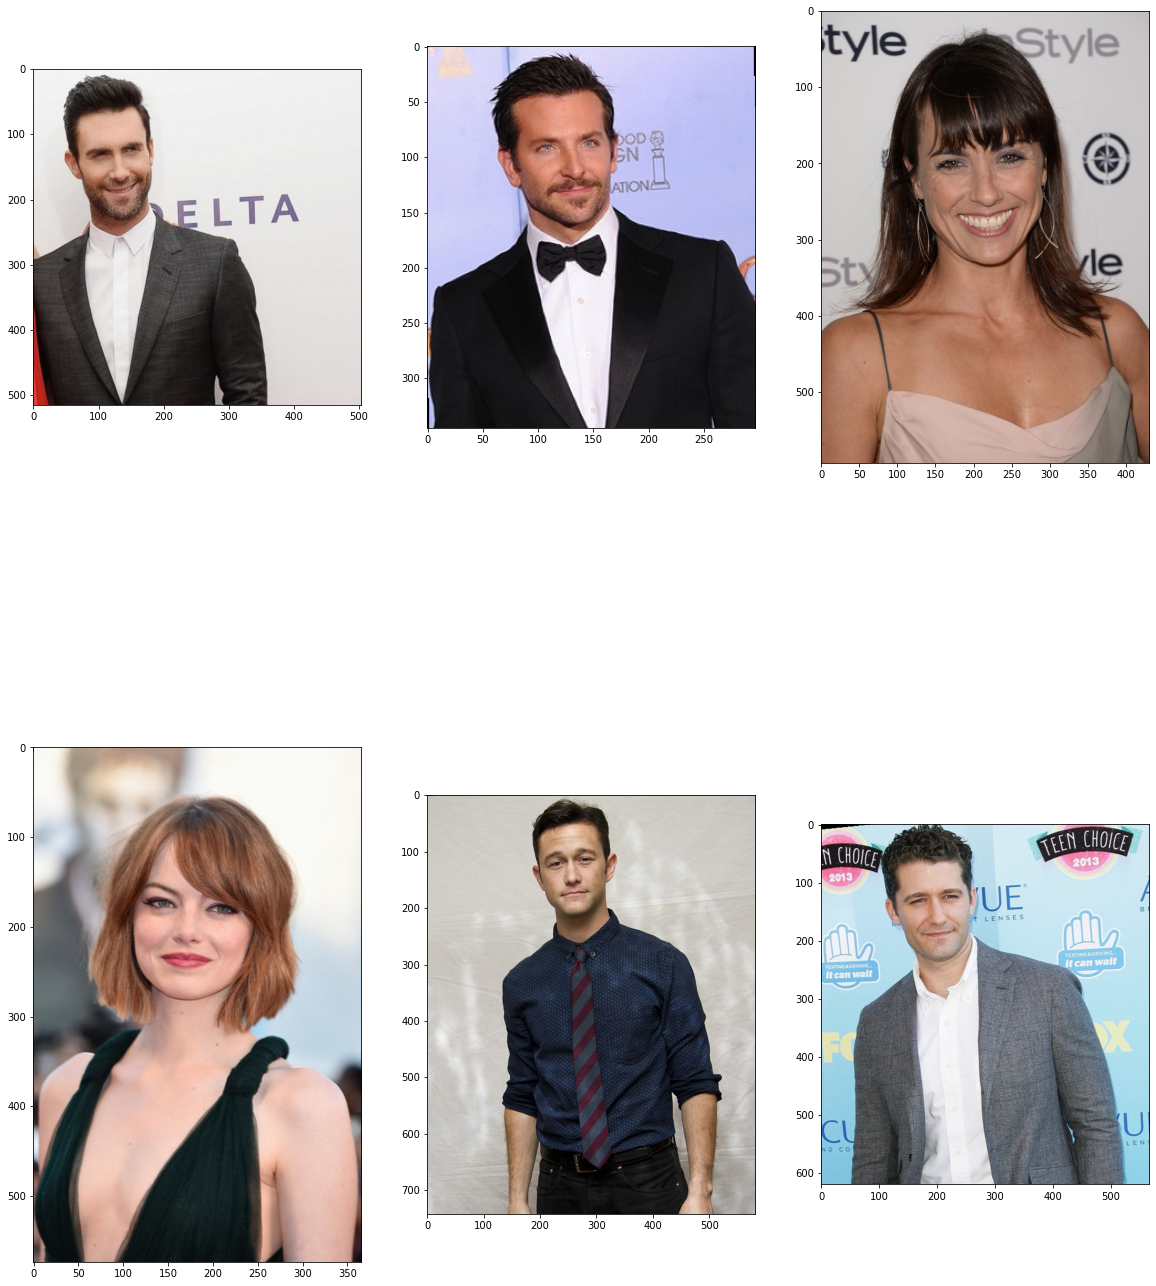

In [6]:
import cv2
import os
import pandas as pd

def load_faces_and_eyes(dir_name = 'C:/Users/JYW/Desktop/Github/repository/ComputerVision/[Coursera]Deep Learning in Computer Vision/week 1/faces_imgs', 
                        eye_path = 'C:/Users/JYW/Desktop/Github/repository/ComputerVision/[Coursera]Deep Learning in Computer Vision/week 1/eyes.pickle'):
    
    face_img = []
    for filename in os.listdir(dir_name):
        img = cv2.imread(os.path.join(dir_name,filename))
        b, g, r = cv2.split(img)   # 
        img = cv2.merge([r,g,b]) # b, r의 순서 바꾸기 for matplotlib : 이 과정이 없으면 색깔이 이상하게 load됨
        
        if img is not None:
            face_img.append(img)
    
    eyes = pd.read_pickle(eye_path).values()
    
    return face_img, eyes

faces, eyes = load_faces_and_eyes()

visualize(faces)